In this project I am going to predict the sentiment of a movie review using n-gram CNN model. As you can see from the 
diagram below. The embedding is fed three times to 3 input layers which is then fed to convolution layers having different kernel sizes.The advantage is that the convolution layer captures the features at different lengths. 

## Model Architecture

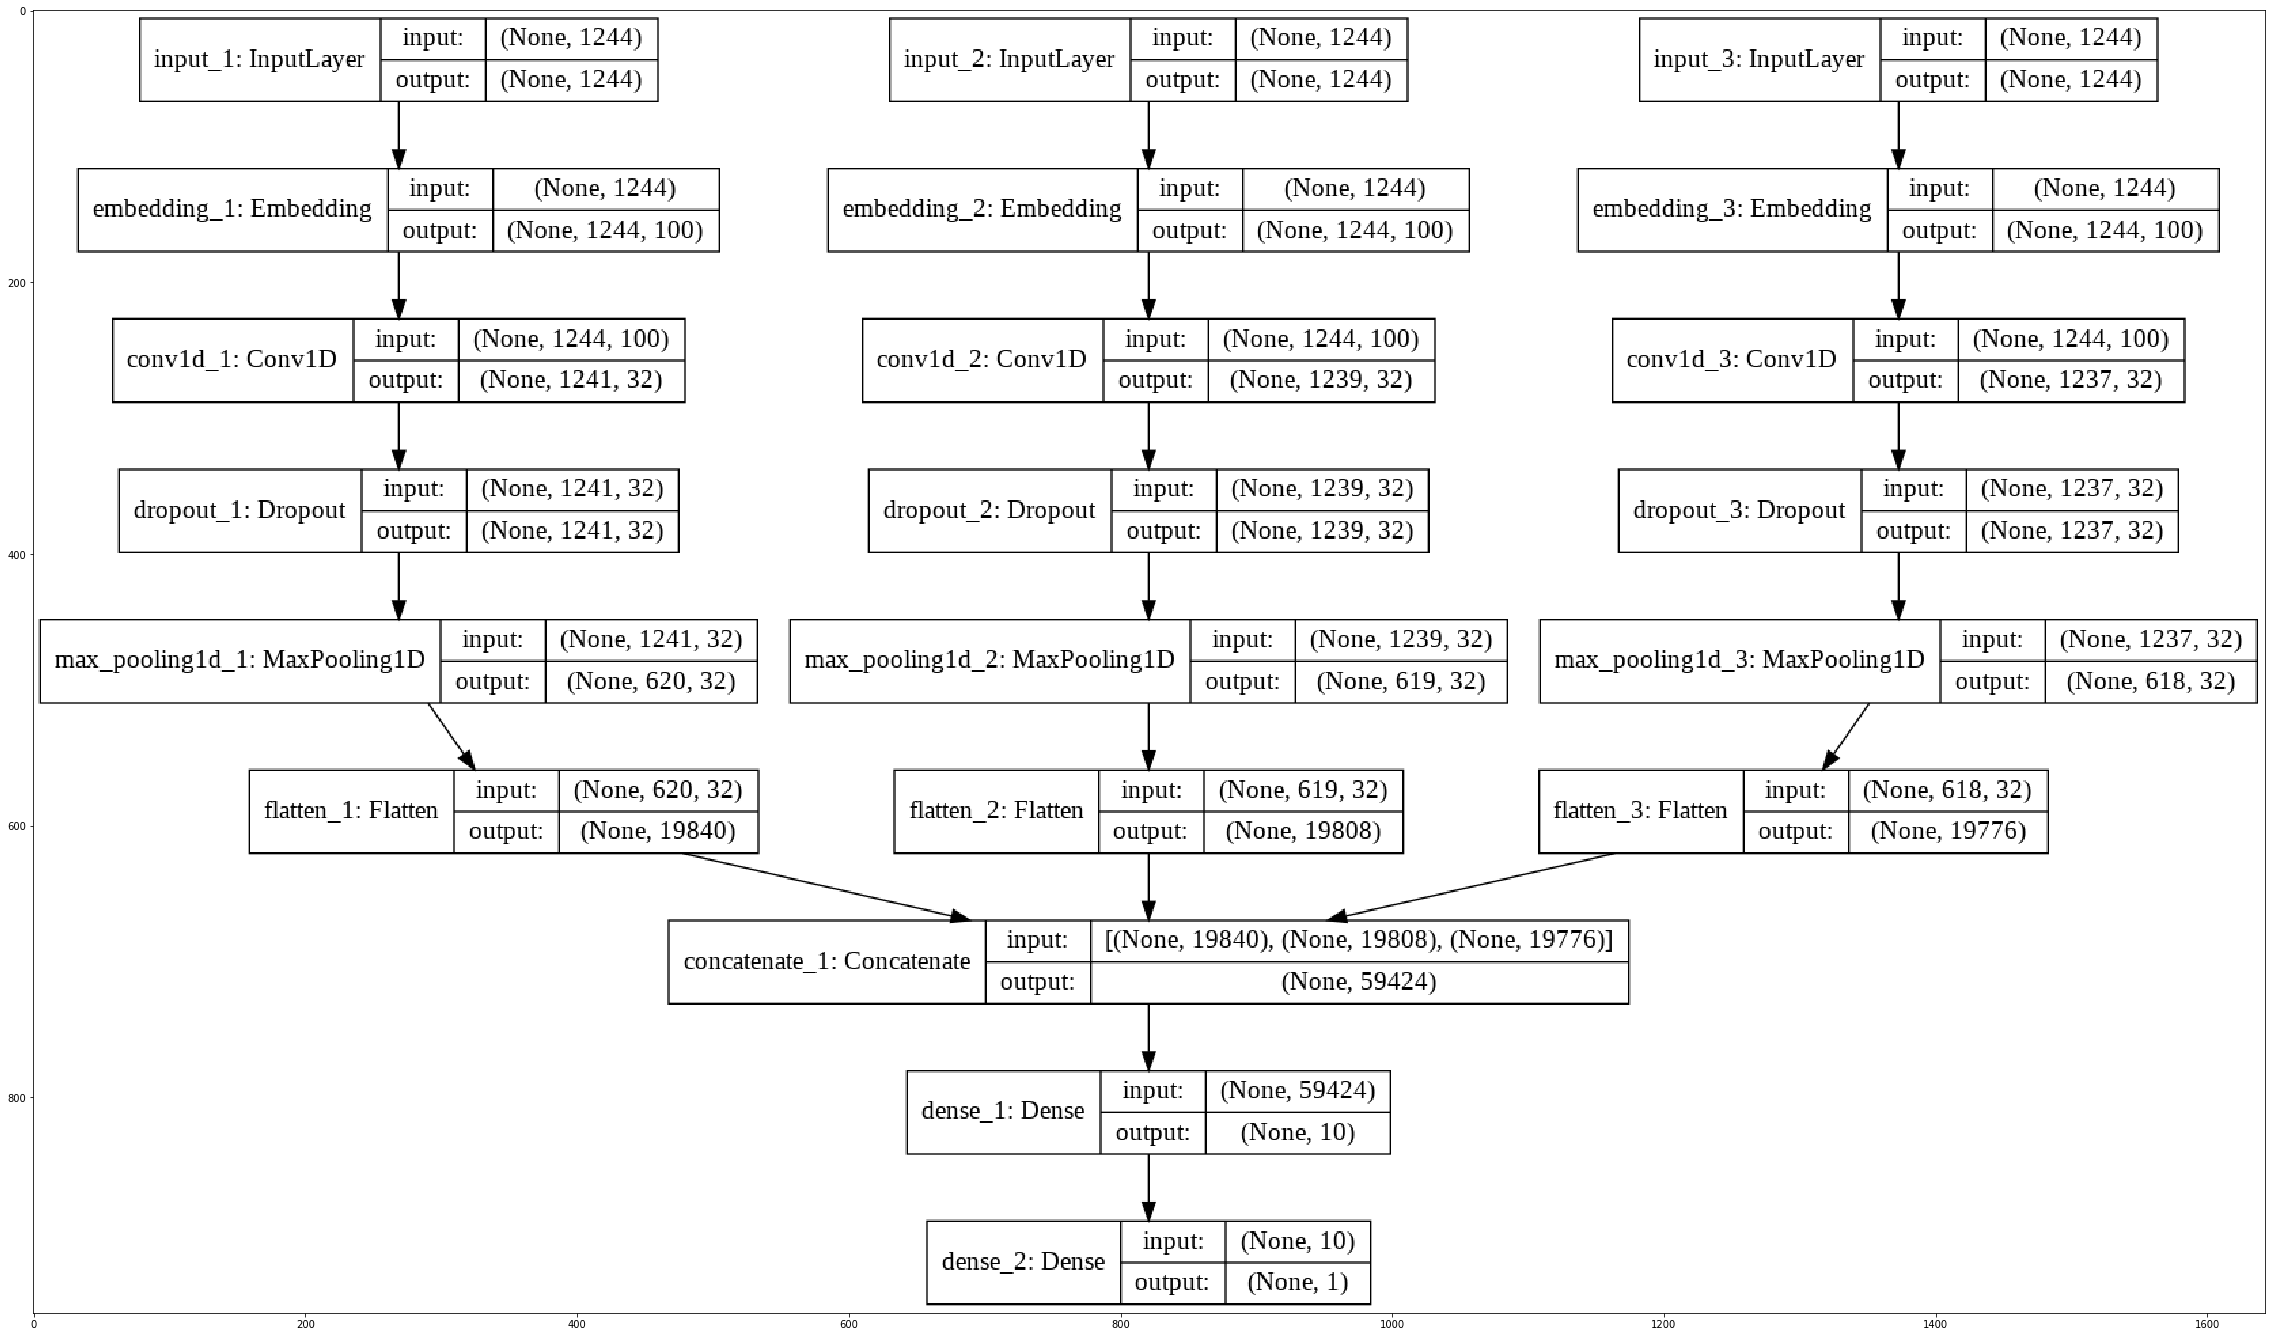

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(40,30))
image= plt.imread('n-gram CNN model for sentiment analysis model.png')
plt.imshow(image)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = 'drive/My Drive/txt_sentoken/'

In [0]:
from pickle import load,dump
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import load_model



In [19]:
from os import listdir
import string
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# load doc into memory
def load_doc(filename):
# open the file as read only
  file = open(filename, 'r')
# read all text
  text = file.read()
# close the file
  file.close()
  return text

In [0]:
# turn a document into clean tokens
def clean_doc(doc, vocab):
# split into tokens by white space
  tokens = doc.split()
# prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
# filter out tokens not in vocab
  tokens = [w for w in tokens if w in vocab]
  tokens = ' '.join(tokens)
  return tokens

In [0]:
# load all documents in a directory and process them using the above clean_doc function,depending on the argument is_train,train and test documents will be processed
def process_docs(directory, vocab, is_train):
  documents = list()
# walk through all files in the folder
  for filename in listdir(directory):
# skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
# create the full path of the file to open
    path = directory + '/' + filename
# load the doc
    doc = load_doc(path)
# clean doc
    tokens = clean_doc(doc, vocab)
# add to list
    documents.append(tokens)
  return documents

In [0]:
# load and clean a dataset according the vocabulary provided
def load_clean_dataset(vocab, is_train):
# load documents
  neg = process_docs(path+'neg', vocab, is_train)
  pos = process_docs(path+'pos', vocab, is_train)
  docs = neg + pos

  # prepare labels
  labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs, labels

In [0]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [0]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
# integer encode
  encoded = tokenizer.texts_to_sequences(docs)
# pad sequences
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [0]:
# load the vocabulary
vocab_filename = path+'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [0]:
# load training data
train_docs, ytrain = load_clean_dataset(vocab, True)

In [28]:
print(len(train_docs),len(ytrain))

(1809, 1809)


In [30]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Vocabulary size: 14815
Maximum length: 1244


In [0]:
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)

In [0]:
# define the model
def define_model(length, vocab_size):
# channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge
  merged = concatenate([flat1, flat2, flat3])
  
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # summarize
  model.summary()
  plot_model(model, show_shapes=True, to_file='n-gram CNN model for sentiment analysis model.png')
  return model

In [33]:
# define model
model = define_model(length, vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1244)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1244)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1244)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embeddin

In [34]:
# fit model
model.fit([Xtrain,Xtrain,Xtrain], array(ytrain), epochs=5, batch_size=16)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1809/1809 [==============================] - 46s 25ms/step - loss: 0.6899 - acc: 0.5362
Epoch 2/5
1809/1809 [==============================] - 44s 25ms/step - loss: 0.2806 - acc: 0.9176
Epoch 3/5
1809/1809 [==============================] - 45s 25ms/step - loss: 0.0153 - acc: 1.0000
Epoch 4/5
1809/1809 [==============================] - 45s 25ms/step - loss: 0.0023 - acc: 1.0000
Epoch 5/5
1809/1809 [==============================] - 44s 25ms/step - loss: 0.0010 - acc: 1.0000


In [0]:
# save the model
model.save('n-gram CNN model for sentiment analysis model.h5')

In [0]:
# load the model
model = load_model('n-gram CNN model for sentiment analysis model.h5')

In [37]:
# evaluate model on training dataset
_, acc = model.evaluate([Xtrain,Xtrain,Xtrain], array(ytrain), verbose=0)
print('Train Accuracy: %.2f' % (acc*100))

Train Accuracy: 100.00


In [0]:
# load training data
test_docs, ytest = load_clean_dataset(vocab, False)

In [0]:
# encode data
Xtest = encode_docs(tokenizer, max_length, test_docs)

In [40]:
# evaluate model on test dataset dataset
_, acc = model.evaluate([Xtest,Xtest,Xtest], array(ytest), verbose=0)
print('Test Accuracy: %.2f' % (acc*100))

Test Accuracy: 86.50
